In [ ]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
module_path

In [2]:
os.chdir(module_path)

In [69]:
import numpy as np
import pandas as pd
from io import StringIO


def create_adj_matrix(edges):
    # after the mapping, nodes are numbered from 0 to max
    num_nodes = np.max(edges)+1
    adj_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
    # The edge list takes into account that the edges are undirected,
    # so already it contains the edges of the two possible permutations of nodes,
    # and so there is no need to insert a 1 in the transposed positions
    adj_matrix[edges[:,0], edges[:,1]] = 1
    #adj_matrix[edges[:,1], edges[:,0]] = 1
    return adj_matrix

def read_mapping(file_path):
    # string indentifying the beginning of the mapping
    start_sentence = "Component 0:"

    data_lines = [] # to store the lines after the target sentence
    # read the file line by line
    with open(file_path, 'r') as file:
        start_reading = False
        for line in file:
            # check if the line starts with the sentence
            if line.startswith(start_sentence):
                start_reading = True

            # once the target sentence is found, collect lines until a blank line is found
            if start_reading:
                # stop when a blank line is encountered
                if line.strip() == "":
                    break
                # append non-blank lines
                data_lines.append(line.strip())

    # convert list of lines into a single string
    data_str = '\n'.join(data_lines)

    # read data into a DataFrame
    return pd.read_csv(StringIO(data_str), sep='\s+') 

def normalize(values):
    #min-max normalization
    min_val = np.min(values)
    max_val = np.max(values)
    return (values-min_val)/(max_val-min_val)

def get_node_features(readme_path, nl_file_path):

    mapping = read_mapping(readme_path)
    # 'value' stands for target value, 'original' stands for original value before the mapping
    mapping.rename(columns={mapping.columns[0]: 'value', mapping.columns[1]: 'original'}, inplace=True)

    node_labels = pd.read_csv(nl_file_path, header=None)
    node_labels.rename(columns={node_labels.columns[0] : 'value'}, inplace=True)

    node_features = pd.merge(node_labels, mapping, on='value', how='left')

    # node type: paper or keyword
    node_features['type'] = pd.to_numeric(node_features.original, errors='coerce')
    node_features['type'] = 1-node_features.type.isna().astype(int) # 0 if paper id, 1 if keyword

    node_features['value'] = normalize(node_features['value'])
    assert np.all(node_features['value'].between(0,1)) #values are in [0,1]

    return node_features[['type', 'value']].values


In [70]:
from os.path import join

base_path = "data\datasets\DBLP_v1"
dataset_name = "DBLP_v1"
readme_path = join(base_path, f"readme.txt")
nl_file_path = join(base_path, f"{dataset_name}_node_labels.txt")

node_features = get_node_features(readme_path, nl_file_path)
node_features

array([[1.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 2.41990127e-05],
       [1.00000000e+00, 4.83980254e-05],
       ...,
       [0.00000000e+00, 1.55478656e-01],
       [0.00000000e+00, 2.42958087e-02],
       [0.00000000e+00, 1.01563256e-01]])

In [52]:
from os.path import join
from src.dataset.instances.graph import GraphInstance

original_instances = []
created_instances = []

base_path = "data\datasets\DBLP_v1"
dataset_name = "DBLP_v1"

#Paths to the files of the DBLP_v1 dataset
#sparse (block diagonal) adjacency matrix for all graphs (node_id, node_id)
adj_file_path = join(base_path, f"{dataset_name}_A.txt")
#column vector of graph identifiers for all nodes of all graphs
gid_file_path = join(base_path, f"{dataset_name}_graph_indicator.txt")
#class labels for all graphs in the dataset
gl_file_path = join(base_path, f"{dataset_name}_graph_labels.txt")
#column vector of node labels
nl_file_path = join(base_path, f"{dataset_name}_node_labels.txt")
#labels for the edges in DS_A_sparse.txt
el_file_path = join(base_path, f"{dataset_name}_edge_labels.txt")
#extract the original labels from readme file
readme_path = join(base_path, f"readme.txt")

#Loading the dataset
labels = np.loadtxt(gl_file_path, dtype=int)
node_labels = np.loadtxt(nl_file_path, dtype=int)
edges = np.genfromtxt(adj_file_path, dtype=int, delimiter=',')
edge_labels = np.loadtxt(el_file_path, dtype=int)
graph_ind = np.loadtxt(gid_file_path, dtype=int)
node_features = get_node_features(readme_path, nl_file_path)

assert np.all(np.diff(graph_ind)>=0) #the array of graph indicators is monotone increasing
#it means that we can subtract the min node of each graph to its nodes,
#in this way we obtain smaller adjacency matrices for all the graphs

#renaming the nodes so that are numbered from 0 to n-1
edges = edges-1
#list of edges in which each node's number is replaced with the graph id it belongs to
edges_gid = graph_ind[edges]

graph_ids = np.unique(graph_ind) #list of graph identifiers
#np.random.shuffle(graph_ids)#shuffle randomly the graph ids
for id in graph_ids:
    #masks for filtering accordingly to the graph identifier
    node_mask = (graph_ind == id) #mask for nodes
    edge_mask = (edges_gid == id) #mask for edges

    filtered_edges = edges[np.any(edge_mask, axis=1)] #select edges of the graph with identifier id
    assert np.all(np.diff(np.unique(filtered_edges))==1)

    min_node = filtered_edges.min() #number identifier of the minimum node in the subgraph
    #subtract the minimum node to the edges, so that nodes are numbered from 0 to k,
    #k is the maximum node of the mapping
    #This step allows us to reduce the size of the adjacency matrix
    #the adjacency matrix now is quadratic in the size of the subgraph
    mapped_edges = filtered_edges-min_node
    assert np.all(np.diff(np.unique(mapped_edges))==1)

    adj_matrix = create_adj_matrix(mapped_edges)

    #if the matrix is singular then ignore the instance
    if not np.isclose(np.linalg.det(adj_matrix), 0):

        original_instances.append({
            "graph": id,
            'label': labels[id-1],
            'edges': filtered_edges,
            'node_features': node_labels.reshape(-1,1),
            'edge_features': edge_labels[np.any(edge_mask, axis=1)]
        })

        created_instances.append(
            GraphInstance(
                id,
                label=labels[id-1],
                data=adj_matrix,
                node_features=node_features[node_mask],
                edge_features=np.eye(3)[edge_labels[np.any(edge_mask, axis=1)]]
            )
        )

In [53]:
original_instances[12]

{'graph': 31,
 'label': 1,
 'edges': array([[313, 314],
        [314, 313],
        [313, 315],
        [315, 313],
        [313, 316],
        [316, 313],
        [314, 315],
        [315, 314],
        [314, 316],
        [316, 314],
        [315, 316],
        [316, 315]]),
 'node_features': array([[   0],
        [   1],
        [   2],
        ...,
        [6425],
        [1004],
        [4197]]),
 'edge_features': array([1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2])}

Graph:  31
label:  1
Edges: 
 [[0 1 1 1]
 [1 0 1 1]
 [1 1 0 1]
 [1 1 1 0]]
Node features: 
 [[1.         0.00646114]
 [0.         0.00220211]
 [0.         0.00648534]
 [0.         0.00370245]]
Edge features: 
 [[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]
Edge list: [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


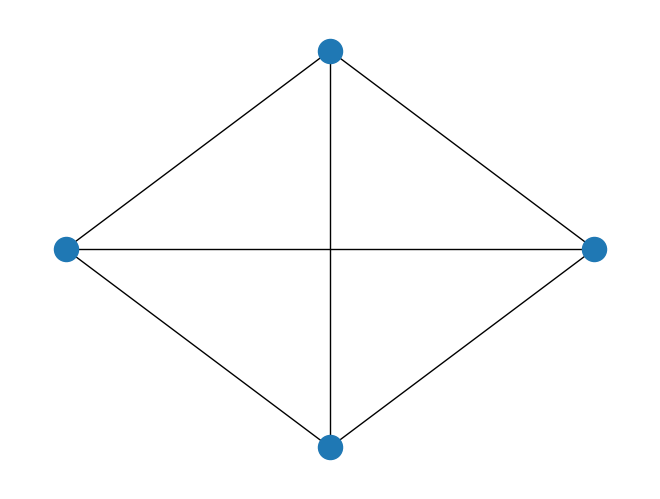

In [54]:
import networkx as nx

graph_instance = created_instances[12]
print("Graph: ", graph_instance.id)
print("label: ", graph_instance.label)
print("Edges: \n", graph_instance.data)
print("Node features: \n", graph_instance.node_features)
print("Edge features: \n", graph_instance.edge_features)
G = graph_instance.get_nx()
print("Edge list:", list(G.edges))
nx.draw_circular(G)